<a href="https://colab.research.google.com/github/hun9008/ML_TeamProject_24SS/blob/main/ViT_%08GradCam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/ML_TeamProject/

/content/drive/MyDrive/ML_TeamProject


In [3]:
ls

data/             images_png/                                        VGG.ipynb
images_gray_jpg/  preprocessed_images_40/                            무_train_labeled_2000/
images_gray_png/  PreTest.ipynb
images_jpg/       vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5


In [4]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 12.2 MB/s eta 0:00:00


In [5]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 9.4 MB/s eta 0:00:00


In [6]:
!pip install vit_keras

In [7]:
import tensorflow as tf
import os
import pickle
import optuna
import pandas as pd
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from optuna.visualization import plot_optimization_history
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow_addons as tfa
from vit_keras import vit
from vit_keras import visualize


gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


1 Physical GPUs, 1 Logical GPUs


In [8]:
image_jpg_path = "/content/drive/My Drive/ML_TeamProject/images_jpg"
image_png_path = "/content/drive/My Drive/ML_TeamProject/images_png"
image_gray_jpg_path = "/content/drive/My Drive/ML_TeamProject/images_gray_jpg"
image_gray_png_path = "/content/drive/My Drive/ML_TeamProject/images_gray_png"

In [9]:
os.chdir("/content/drive/My Drive/ML_TeamProject/images_png")
!ls

images_png.zip	incipient  mature  no  overripe


In [10]:
# !unzip -q images_gray_jpg.zip

In [11]:
!ls

images_png.zip	incipient  mature  no  overripe


In [12]:
image_path = image_png_path

In [ ]:
# os.rename('overripe_train_labeled_2000','overripe')
# os.rename('no_train_labeled_2000','no')
# os.rename('mature_train_labeled_2000','mature')
# os.rename('incipient_train_labeled_2000','incipient')

In [13]:
!ls

images_png.zip	incipient  mature  no  overripe


Pickle load to variable

In [14]:
os.chdir(os.path.join(image_path, 'overripe'))
with open('zero_centering.pkl', 'rb') as f:
     overripe = pickle.load(f)
     print('overripe : ', len(overripe))
os.chdir(os.path.join(image_path, 'no'))
with open('zero_centering.pkl', 'rb') as f:
     no = pickle.load(f)
     print('no : ', len(no))

os.chdir(os.path.join(image_path, 'mature'))
with open('zero_centering.pkl', 'rb') as f:
     mature = pickle.load(f)
     print('mature : ', len(mature))

os.chdir(os.path.join(image_path, 'incipient'))
with open('zero_centering.pkl', 'rb') as f:
     incipient = pickle.load(f)
     print('incipient : ', len(incipient))

overripe :  2000
no :  2000
mature :  2000
incipient :  2000


Dictionary to numpy array

In [15]:
# overripe의 모든 사진에 대해 반복
overripe_data_list = []

for filename, data in overripe.items():
    zero_centering_value = data.get('zero_centering')
    overripe_data_list.append(np.array(zero_centering_value))

# 리스트를 NumPy 배열로 변환
overripe_data = np.array(overripe_data_list)

# 확인을 위해 배열의 크기 출력
print("overripe_data shape:", overripe_data.shape)
no_data_list = []

for filename, data in no.items():
    zero_centering_value = data.get('zero_centering')
    no_data_list.append(np.array(zero_centering_value))

# 리스트를 NumPy 배열로 변환
no_data = np.array(no_data_list)

# 확인을 위해 배열의 크기 출력
print("no_data shape:", no_data.shape)

mature_data_list = []

for filename, data in mature.items():
    zero_centering_value = data.get('zero_centering')
    mature_data_list.append(np.array(zero_centering_value))

# 리스트를 NumPy 배열로 변환
mature_data = np.array(mature_data_list)

# 확인을 위해 배열의 크기 출력
print("mature_data shape:", mature_data.shape)

incipient_data_list = []

for filename, data in incipient.items():
    zero_centering_value = data.get('zero_centering')
    incipient_data_list.append(np.array(zero_centering_value))

# 리스트를 NumPy 배열로 변환
incipient_data = np.array(incipient_data_list)

# 확인을 위해 배열의 크기 출력
print("incipient_data shape:", incipient_data.shape)

overripe_data shape: (2000, 224, 224, 3)
no_data shape: (2000, 224, 224, 3)
mature_data shape: (2000, 224, 224, 3)
incipient_data shape: (2000, 224, 224, 3)


Train Val Test split (0.75:0.15:0.15)

In [16]:
# 데이터를 train/validation/test로 나누기
X = np.concatenate((overripe_data, no_data, mature_data, incipient_data), axis=0)
y = np.concatenate((np.zeros(overripe_data.shape[0]), np.ones(no_data.shape[0]),
                    2*np.ones(mature_data.shape[0]), 3*np.ones(incipient_data.shape[0])))

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(5600, 224, 224, 3)
(1200, 224, 224, 3)
(1200, 224, 224, 3)


y one-hot

In [17]:
y_train_one_hot = to_categorical(y_train)
y_val_one_hot = to_categorical(y_val)
y_test_one_hot = to_categorical(y_test)

In [18]:
# memory reduce
del overripe, no, mature, incipient
del overripe_data, no_data, mature_data, incipient_data
del overripe_data_list, no_data_list, mature_data_list, incipient_data_list
del X, y
del y_train, y_temp, y_val, y_test

Training & Test

In [19]:
vit_model = vit.vit_b32(
        image_size = 224,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 4)

353253686/353253686 [==============================] - 3s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


In [20]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(5600, 224, 224, 3)
(1200, 224, 224, 3)
(1200, 224, 224, 3)


In [21]:
X_train.all()

True

In [22]:
# def train_vgg16_model():

  # Freeze the base model layers
  # for layer in base_model.layers:
  #     layer.trainable = False

# Add custom top layers for classification
model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(11, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(4, 'softmax')
    ],
    name = 'vision_transformer')

model.summary()

  # Compile model
  # optimizer = Adam(lr=5.520238899015578e-05)
learning_rate = 1e-4

optimizer = tfa.optimizers.RectifiedAdam(learning_rate = learning_rate)

model.compile(optimizer = optimizer,
                loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2),
                metrics = ['accuracy'])
batch_size = 16

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                factor = 0.2,
                                                patience = 2,
                                                verbose = 1,
                                                min_delta = 1e-4,
                                                min_lr = 1e-6,
                                                mode = 'max')

earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                min_delta = 1e-4,
                                                patience = 5,
                                                mode = 'max',
                                                restore_best_weights = True,
                                                verbose = 1)

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = './model.hdf5',
                                                  monitor = 'val_accuracy',
                                                  verbose = 1,
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')

callbacks = [earlystopping, reduce_lr, checkpointer]

model.fit(x = X_train,
          y = y_train_one_hot,
          # steps_per_epoch = batch_size,
          validation_data = (X_val, y_val_one_hot),
          # validation_steps = batch_size,
          epochs = 50,
          callbacks = callbacks)


Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b32 (Functional)        (None, 768)               87455232  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 batch_normalization (Batch  (None, 768)               3072      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 11)                8459      
                                                                 
 batch_normalization_1 (Bat  (None, 11)                44        
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 4)          

In [23]:
test_loss, test_acc = model.evaluate(X_test, y_test_one_hot)
print('Test accuracy:', test_acc)

38/38 [==============================] - 5s 120ms/step - loss: 0.9271 - accuracy: 0.7892
Test accuracy: 0.7891666889190674


In [24]:
!git clone https://github.com/jacobgil/pytorch-grad-cam.git
!cd pytorch-grad-cam
!pip install -e .

fatal: destination path 'pytorch-grad-cam' already exists and is not an empty directory.
Obtaining file:///content/drive/MyDrive/ML_TeamProject/images_png/incipient
ERROR: file:///content/drive/MyDrive/ML_TeamProject/images_png/incipient does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


In [25]:
cd pytorch-grad-cam

/content/drive/MyDrive/ML_TeamProject/images_png/incipient/pytorch-grad-cam


In [26]:
!pip install -e .

Obtaining file:///content/drive/MyDrive/ML_TeamProject/images_png/incipient/pytorch-grad-cam
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Usi

In [123]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 23.1 MB/s eta 0:00:00


In [124]:
import torch
from torch.nn import functional as F
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from transformers import ViTModel, ViTConfig
import timm
import numpy as np
import cv2
from PIL import Image

In [31]:
def reshape_transform(tensor, height=14, width=14):
    result = tensor[:, 1:, :].reshape(tensor.size(0),
                                      height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

In [125]:
def vit_grad_cam(image_path, class_idx):
    # Load ViT model
    model = torch.hub.load('facebookresearch/deit:main',
                           'deit_tiny_patch16_224', pretrained=True)
    model.eval()
    target_layers = [model.blocks[-1].norm1]

    rgb_img = cv2.imread(image_path, 1)[:, :, ::-1]
    rgb_img = cv2.resize(rgb_img, (224, 224))
    rgb_img = np.float32(rgb_img) / 255
    input_tensor = preprocess_image(rgb_img, mean=[0.5, 0.5, 0.5],
                                    std=[0.5, 0.5, 0.5])

    cam = GradCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)
    grayscale_cam = cam(input_tensor=input_tensor)

    grayscale_cam = grayscale_cam[0, :]
    cam_image = show_cam_on_image(rgb_img, grayscale_cam)
    return cam_image

In [118]:
cd /content/drive/MyDrive/ML_TeamProject/images_png

/content/drive/MyDrive/ML_TeamProject/images_png


In [126]:
# Set image path and target class index
image_path = 'incipient/crop_D25_2f21093e-60a5-11ec-8402-0a7404972c70.png'
class_idx = 0

# Get Grad-CAM image
grad_cam_image = vit_grad_cam(image_path, class_idx)
cv2.imwrite('grad_cam.jpg', grad_cam_image)

# Display Grad-CAM image
# img = Image.fromarray(grad_cam_image)
# display(img)

Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main
/root/.cache/torch/hub/facebookresearch_deit_main/models.py:63: UserWarning: Overwriting deit_tiny_patch16_224 in registry with models.deit_tiny_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def deit_tiny_patch16_224(pretrained=False, **kwargs):
/root/.cache/torch/hub/facebookresearch_deit_main/models.py:78: UserWarning: Overwriting deit_small_patch16_224 in registry with models.deit_small_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def deit_small_patch16_224(pretrained=False, **kwargs):
/root/.cache/torch/hub/facebookresearch_deit_main/models.py:93: UserWarning: Overwriting deit_base_patch16_224 in registry with models.deit_base_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.

True

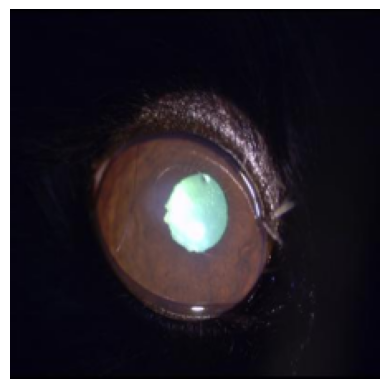

In [130]:
image = cv2.imread(image_path)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

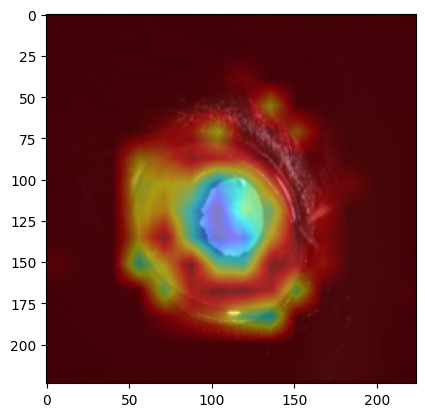

In [127]:
plt.imshow(grad_cam_image)